# Lab 2 (Part B) - Linear regression with one feature

Make sure that you check the videos of lecture 2 before starting this Lab:
- Introduction to Linear Regression: https://youtu.be/-wmjwMWRsZU
- Introduction to Nonlinear Regression: https://youtu.be/Hyu8QMLEHrE

<div class="alert alert-block alert-danger">

Please complete this Jupyter Notebook and upload it as a zip file to Blackboard, preferably __before 21 Sept 2020__. You can ask questions and get help in the "Discussions" section on Blackboard, or during the live Monday sessions in Zoom.
</div>

In this part of the Lab, you will implement linear regression with one variable to predict profits for a food truck. Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The company already has trucks in various cities and you have data for profits and populations from the cities. You would like to use this data to help you select which city to expand to next.

First, please select the Python code cell below and run it to initialize some plots. You DO NOT have to understand the code in this cell.

In [1]:
# Always run this cell before anything else. DO NOT modify this code.
%matplotlib notebook

import sys
sys.path.insert(0, 'labutils/')

from lab2utils import lab2partB1
lab2B1 = lab2partB1()

# 1. Loading the data
We have a file `PopulationProfit.csv` which contains the dataset for our linear regression problem. The first column is the population of a city and the second column is the profit of a food truck in that city. A negative value for profit indicates a loss.

<img src="imgs/PopulationProfiteScreenshotLab2B.png" style="width: 200px;"/>

The following Python code helps you load the dataset from the csv file into the variables $X$ and $y$. The variable $X$ is the input data, which is a matrix with one column (one feature) corresponding to the population. The variable $y$ is the output values corresponding to the profit. Read the following code and print a small subset of the variables $X$ and $y$ to see what they look like.

**Note about some variable names in Python**: In this Lab and all the next ones, we will use the following:
- The input dataset is denoted by `X` (big capital letter). This is a matrix $X \in \mathbb{R}^{n \times d}$.
- The small letter `y` refers to the array containing $n$ outputs, i.e. one output for each data-point. This is a vector $y \in \mathbb{R}^n$.
- The small letter `x` refers to the array representing one data-point (feature-vector) from the dataset (i.e. `x` is one row of `X`). This data-point is a vector $x \in \mathbb{R}^d$.

In [2]:
import numpy as np

# Loading the data from the file into mydata
filename = "datasets/PopulationProfit.csv"
mydata = np.genfromtxt(filename, delimiter=",")

# We have n cities (each line corresponds to one city)
n = len(mydata)

# We take the population values from mydata and reshape it into a matrix X of n 
# lines and 1 column (population), i.e. an array of n 1-dimensional feature-vectors
X = mydata[:, 0].reshape(n, 1)

# We take the profit values from mydata (-1 refers to the last column). So, 
# y is the vector of outputs (profits), i.e. an array of n scalar values
y = mydata[:, -1]

""" TODO:
You can print a small subset of X and y here to see what they look like.
"""
print(X[:10])
print(y[:10])

[[6.1101]
 [5.5277]
 [8.5186]
 [7.0032]
 [5.8598]
 [8.3829]
 [7.4764]
 [8.5781]
 [6.4862]
 [5.0546]]
[17.592   9.1302 13.662  11.854   6.8233 11.886   4.3483 12.      6.5987
  3.8166]


# 2. Visualizing the data
Before starting on any task, it is often useful to understand the data by visualizing it. For this dataset, you can use a scatter plot to visualize the data, since it has only two properties to plot (profit and population). Complete the *TODO*s in the Python code below to do this scatter plot.

*Note*: Many other problems that you will encounter in real life are multi-dimensional and can't be plotted on a simple 2-dimensional plot.

Make sure that the result of your plot looks like the following figure, with the same red ${\color{red}+}$ markers and axis labels. To learn more about plotting in Python, you can check the documentation of the **matplotlib** Python Library.

<img src="imgs/scatterLab2B.png" style="width: 500px;"/>

<IPython.core.display.Javascript object>


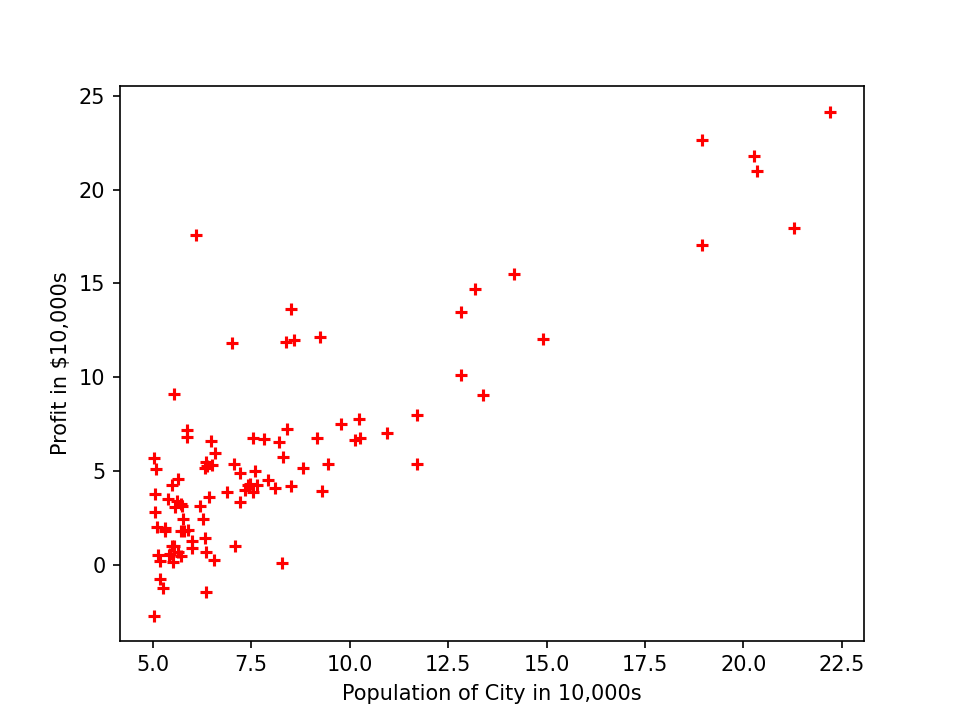

In [3]:
import matplotlib.pylab as plt

# We get the list of values of the 1st feature (column 0 from X) as follows
population = X[:, 0] # take the values at "all lines" and "column 0"

""" TODO:
Complete the lines below to do a scatter plot showing 
the population vs. the profit in various cities.
"""
fig, ax = plt.subplots()
# TODO: Do a scatter plot as shown in the figure
ax.scatter(population, y, marker='+', color='r')
# TODO: The label on the x-axis should be "Population of City in 10,000s"
ax.set_xlabel("Population of City in 10,000s")
# TODO: The label on the y-axis should be "Profit in $10,000s"
ax.set_ylabel("Profit in $10,000s")
fig.show()


# 3. Linear Regression from Scrach
You will use gradient descent to fit the linear regression parameters $\theta$ to our dataset. As you know from the lecture, the objective of an ordinary linear regression is to minimize the following cost function:
$$E(\theta) = \frac{1}{2n} \sum_{i=1}^{n} [h_{\theta}(x^{(i)}) - y^{(i)}]^2$$

where the hypothesis $h_{\theta}(x)$ is given by the linear model:

$$
h_{\theta}(x) = \theta^T x = \theta_0 + \theta_1 x_1 \quad \quad \quad
\text{ with } \theta = \begin{pmatrix} \theta_0 \\ \theta_1 \\ \end{pmatrix},\quad x = \begin{pmatrix} 1 \\ x_1 \\ \end{pmatrix}
$$

Recall that the parameters of your model are the $\theta_j$ values. These are the values you will adjust to minimize the cost $E(\theta)$. To do this, you will use the batch gradient descent algorithm, where at each iteration the parameters vector $\theta$ is updated (i.e. all parameters $\theta_j$ are updated simultaneously). With each step of gradient descent, your parameters $\theta_j$ come closer to the optimal values that will achieve the lowest cost $E(\theta)$.

**Implementation Note**: In Python, each data-point $x$ is stored as a row in the matrix $X$. To take into account the intercept term ($\theta_0$), you can add an additional first column to $X$ and set its values to $1$. This allows us to treat $x_0 = 1$ as simply another *feature*. To add a first column of 1's to $X$ you can call the function `add_all_ones_column(X)` defined below, which takes a matrix as argument and returns a new matrix with an additional first column (of ones).

In [4]:
# This function takes a matrix as argument and returns a new matrix with an additional first column (of ones)
# You don't have to understand the code of this function in details (just understand what it is supposed to do)
def add_all_ones_column(X):
    n, d = X.shape # dimension of the matrix X (n lines, d columns)
    XX = np.ones((n, d+1)) # new matrix of all ones with one additional column
    XX[:, 1:] = X # set X starting from column 1 (keep only column 0 unchanged)
    return XX

# The following line creates a new data matrix with an additional first column (of ones)
X_new = add_all_ones_column(X)

""" TODO:
You can print a small subset of X_new here to see how it looks like 
"""
print(X_new[:10])

[[1.     6.1101]
 [1.     5.5277]
 [1.     8.5186]
 [1.     7.0032]
 [1.     5.8598]
 [1.     8.3829]
 [1.     7.4764]
 [1.     8.5781]
 [1.     6.4862]
 [1.     5.0546]]


As you perform gradient descent to learn the parameters vector $\theta$, it is helpful to monitor the convergence by computing the cost $E(\theta)$. In the Python code below, you are asked to implement the hypothesis function `h(theta, x)` and the cost function `E(theta, X, y)`, so that you can use it later to check the convergence of your gradient descent implementation.

If you implement the cost function correctly and call it once using $\theta$ initialized to zeros, `X_new` and `y`, then you will see the cost $\sim 32.07$ printed to the screen.

In [5]:
""" TODO:
Write here the definition of the hypothesis function h for linear regression.
"""
def h(theta, x):
    '''
       x@theta since our x=(1 x1 
                            1 x2
                            1 x3
                            . ..
                            . ..
                            1 xn
                            ) 
       using theta.T@x will result in non defineable matrix multiplication                     
    '''
    hypfunc = x@theta
    return hypfunc


""" TODO:
Write here the definition of the cost function E. Try to use a vectorized
implementation if possible (if you cannot then its fine to use loops).
"""
def E(theta, X, y):
    cost = ((h(theta, X) - y)**2)
    return sum(cost)/(2*n)


# TODO: Uncomment the following lines to test your implemented cost function
theta = np.array([0, 0])
print("Initial cost: ", E(theta, X_new, y)) # Notice that we are calling it with X_new (not with X)

Initial cost:  32.072733877455654


Next, you will implement gradient descent. To do so, you need first to implement $\nabla E(\theta)$ the gradient of the cost function. $\nabla E(\theta)$ is a vector containing the derivative of the cost function $E(\theta)$ with respect to each parameter $\theta_j$:

$$
\nabla E(\theta) = \left ( \frac{\partial E(\theta)}{\partial \theta_0}, \frac{\partial E(\theta)}{\partial \theta_1} \right )
\quad \quad \text{ where }
\frac{\partial E(\theta)}{\partial \theta_j} = \frac{1}{n} \sum_{i=1}^{n} \left [ h_{\theta}(x^{(i)}) - y^{(i)} \right ] ~ x^{(i)}_j
$$

Complete the Python code below to implement `gradE(theta, X, y)`, the gradient of the cost function: $\nabla F(\theta)$.

If you implement the gradient function correctly and call it once using $\theta$ initialized to zeros, `X_new` and `y`, then it will return: `[-5.839  -65.328]`

In [6]:
""" TODO:
Write the definition of the function gradE(...), the gradient of the cost. 
It should return an array containing the derivative of the cost function 
with respect to each parameter theta[j]. Try to use a vectorized implementation 
if possible (if you cannot then its fine to use loops).
"""
def gradE(theta, X, y):
    grad = (h(theta, X) - y)@X
    return (grad)/n


# TODO: Uncomment the following lines to test your implemented gradient function
theta = np.array([0, 0])
print("Test: ", gradE(theta, X_new, y)) # expect [-5.839  -65.328] if your implementation is correct.

Test:  [ -5.83913505 -65.32884975]


To implement gradient descent, you will need a loop structure in which you update $\theta$ within each iteration. Use a learning rate $\alpha = 0.01$.

As you program, make sure you understand what you are trying to optimize and what is being updated. Keep in mind that the cost $E(\theta)$ is parameterized by the vector $\theta$, not $X$ and $y$. That is, we minimize the value of $E(\theta)$ by changing the values of the vector $\theta$, not by changing $X$ or $y$. Please refer to the lecture slides about linear regression if you are uncertain.

A good way to verify that gradient descent is working correctly is to look at the value of $E(\theta)$ and check that it is decreasing with each step. Assuming you have implemented gradient descent and $E(\theta)$ correctly, your value of $E(\theta)$ should never increase, and should converge to a steady value by the end of the algorithm.

<IPython.core.display.Javascript object>


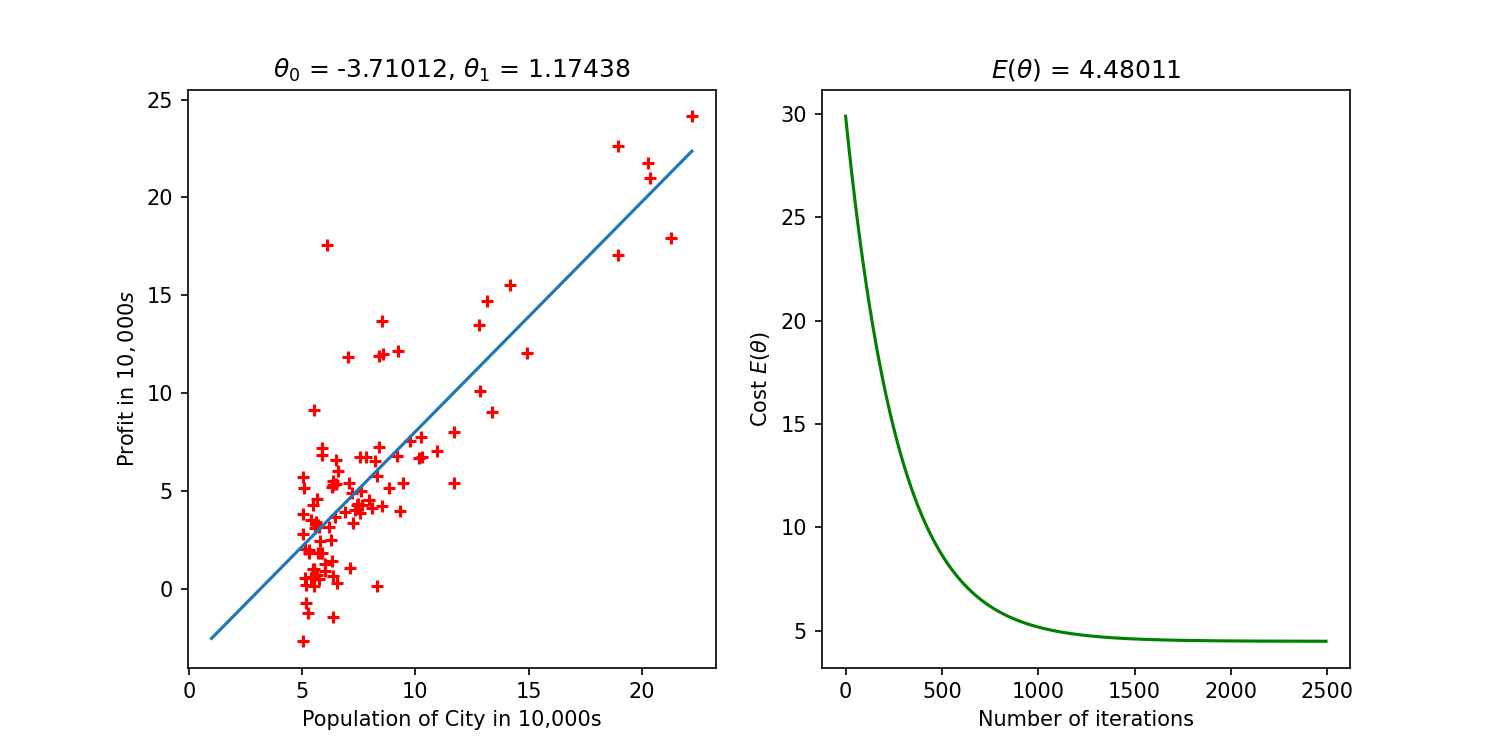

In [7]:
alpha = 0.01                     # The learning rate of gradient descent
theta = np.array([10, -30])      # Some initial parameters vector: theta = [theta_0, theta_1, ...]
max_iterations = 5000            # Maximum number of iterations
epsilon = 0.00001                # Some small number to test for convergence (i.e. to stop if F(a) does not decrease too much)

for itr in range(max_iterations):
    lab2B1.plot(itr, E, theta, X_new, y) # This plots an animation (DO NOT modify this line)
    prev = E(theta, X_new, y) # Save the value of E(theta)
    
    """ TODO:
    Write here the gradient descent step to update the parameters vector `theta`.
    All the parameter values in theta should be updated simultaneously.
    Hint: You need to use `alpha` and `gradE(theta, X_new, y)`
    """
    theta = theta - alpha*gradE(theta, X_new, y) 
    
    """ TODO:
    Replace the boolean variable `CONDITION` below with a condition to break-out
    of the loop if we are close to convergence. Hint: You need to use `prev` the previous 
    value of E(theta, X_new, y), the current value of `E(theta, X_new, y)`, and `epsilon`.
    """
    CONDITION = abs(E(theta, X_new, y) - prev) < epsilon # Replace True with a boolean condition
    if CONDITION:
        break


Finally, use your final values for $\theta$ (that you got after gradient descent finishes running) to make predictions on profits in areas of 35,000 and 70,000 people; i.e. you are asked to write code to make two predictions:
- one prediction for a new input `[3.5]` (area of 35,000 people)
- and another prediction for a new input `[7]` (area of 70,000 people).

In [8]:
""" TODO:
Write a simple code to predict the profit in areas of 35,000 and 70,000 people
"""
X_test = np.array([
    [1, 3.5],
    [1, 7.0]
])
print(theta)
predictions = h(theta, X_test)
prediction1 = predictions[0]
prediction2 = predictions[1]
print(prediction1, prediction2)

[-3.72148426  1.17552366]
0.39284854340918196 4.507181347895143


# 4. Linear Regression with scikit-learn (sklearn)
You implemented an *ordinary linear regression* from scratch by optimizing the "mean squared error" cost function using gradient descent. This (implementation from scrach) was important to help you understand how it works. However, in real-world applications, one would typically use ML libraries such as *scikit-learn*. Such libraries simplify our life a lot (but it is still often necessary to understand how the ML algorithms work under the hood).

In this section, you will see how simple it is to use the *scikit-learn* library to do the same ordinary linear regression.

First, make sure that *scikit-learn* is installed. If not, you can install it by typing the following command on your command line: `pip install scikit-learn` or you can check the following link for more information: https://scikit-learn.org/stable/install.html

The following code imports and trains a `LinearRegression` model on our training dataset (in just one line of code).

In [9]:
# Import the LinearRegression class
from sklearn.linear_model import LinearRegression

"""
Instantiate a LinearRegression() model and train it by calling fit on the training 
data (input data X and outputs y). Note that we use the original data X, we 
don't need to add a column of ones to X. Scikit-learn takes care of such details.
"""
reg = LinearRegression().fit(X, y) # Training

Now you can print the learned (i.e. estimated) parameters and compare them with the previous vector of parameters `theta` that you got. You should see that they are similar (not exactly the same, but very similar). In the following code `reg.intercept_` is a scalar value that corresponds to $\theta_0$, and `reg.coef_` is a the vector of parameters (starting from $\theta_1$).

In [10]:
print("theta_0 learned using your initial code: ", theta[0])
print("theta_0 learned using sklearn: ", reg.intercept_)
print()
print("prameters [theta_1, ...] learned using your initial code: ", theta[1:]) # starting from theta_1
print("prameters [theta_1, ...] learned using sklearn: ", reg.coef_)

theta_0 learned using your initial code:  -3.7214842610767795
theta_0 learned using sklearn:  -3.89578087831185

prameters [theta_1, ...] learned using your initial code:  [1.17552366]
prameters [theta_1, ...] learned using sklearn:  [1.19303364]


Now suppose we have two new test data-points `[3.5]` and `[7]` (i.e. one dimensional data, as we have one feature) and we want to predict their corresponding output. The following code makes predictions using your trained regression model `reg` (in just one line of code).

In [11]:
# Our test data is:
X_test = np.array([
    [3.5], # first data-point
    [7]    # second data-point
])

# Now we can predict the outputs simply using:
y_pred = reg.predict(X_test)
print( y_pred )

# These predictions should be similar (close enough) to what you got with your own code previously.

[0.27983688 4.45545463]


You can check the following link for more information about this ordinary linear regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
Later in the course, we will see more sophisticated linear regression models when we talk about overfitting, generalization, and regularization.